## Display of the geometry configuration

In [1]:
import os
import sys
import tables as tb
import numpy  as np
sys.path.append('/data5/users/carmenromo/Analysis/Christoph_code')
import analysis_utils     as ats
import optimization_utils as ots
sys.path.append('/data5/users/carmenromo/Analysis/scripts_before_dataframes/')
import reco_functions as rf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [7]:
#eventsPath = '/Users/carmenromoluque/Desktop'
#file_name  = 'full_ring_NEXT_v1_05_02_nexus_p5_01_00_pos0.50.50.0.pet.h5'
eventsPath = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/narrow_ring/data_ring'
file_name  = 'full_ring_iradius165mm_z140mm_depth2.5cm_pitch7mm.000.pet.h5'
filename   = f"{eventsPath}/{file_name}"
h5in       = tb.open_file(filename, mode='r')
h5config   = h5in.root.MC.configuration
h5extents  = h5in.root.MC.extents

## Initialization of the variables
gen_evts    = saved_evts   = 0
depth_ring  = irad_ring    = 0
sipms_pitch = sipms_rows   = sipms_size   = 0
inst_faces  = min_costheta = max_costheta = 0
numb_x      = numb_y       = numb_z       = 0

print('--------------------------------------')
print('------ CONFIGURATION PARAMETERS ------')
print('--------------------------------------')
print('')
for row in h5config:
    param_name = row['param_key'].decode('utf-8','ignore')
    if param_name.find('num_events') >= 0:
        gen_evts = row['param_value'].decode('utf-8','ignore')
        print(f"Generated events            : {gen_evts}")
    elif param_name.find('saved_events') >= 0:
        saved_evts = row['param_value'].decode('utf-8','ignore')
        print(f"Saved events                : {saved_evts}")
    elif param_name.find('/Geometry/FullRingInfinity/depth') >= 0:
        param_value = row['param_value'].decode('utf-8','ignore')
        depth_ring, unit  = param_value.split()
        if unit == 'cm':
            depth_ring = float(depth_ring)*10
            unit = 'mm'
        print(f"Depth of the ring           : {depth_ring} {unit}")
    elif param_name.find('/Geometry/FullRingInfinity/inner_radius') >= 0:
        param_value = row['param_value'].decode('utf-8','ignore')
        irad_ring, unit  = param_value.split()
        print(f"Internal radius of the ring : {irad_ring} {unit}")
    elif param_name.find('/Geometry/FullRingInfinity/pitch') >= 0:
        param_value = row['param_value'].decode('utf-8','ignore')
        sipms_pitch, unit  = param_value.split()
        print(f"Pitch of the sipms          : {sipms_pitch} {unit}")
    elif param_name.find('/Geometry/SiPMpet/size') >= 0:
        param_value = row['param_value'].decode('utf-8','ignore')
        sipms_size, unit  = param_value.split()
        print(f"Size of the sipms           : {sipms_size} {unit}")
    elif param_name.find('/Geometry/FullRingInfinity/sipm_rows') >= 0:
        sipms_rows = row['param_value'].decode('utf-8','ignore')
        print(f"Number of rows of the sipms : {sipms_rows}")
    elif param_name.find('/Geometry/FullRingInfinity/instrumented_faces') >= 0:
        inst_faces = row['param_value'].decode('utf-8','ignore')
        print(f"Number of instrumented faces: {inst_faces}")
    elif param_name.find('/Generator/Back2back/min_costheta') >= 0:
        min_costheta = row['param_value'].decode('utf-8','ignore')
    elif param_name.find('/Generator/Back2back/max_costheta') >= 0:
        max_costheta = row['param_value'].decode('utf-8','ignore')
        print(f"costheta interval           : [{min_costheta}, {max_costheta}]")
    elif param_name.find('/Geometry/FullRingInfinity/specific_vertex_X') >= 0:
        source_x = row['param_value'].decode('utf-8','ignore')
        numb_x, unit_x = source_x.split()
    elif param_name.find('/Geometry/FullRingInfinity/specific_vertex_Y') >= 0:
        source_y = row['param_value'].decode('utf-8','ignore')
        numb_y, unit_y = source_y.split()
    elif param_name.find('/Geometry/FullRingInfinity/specific_vertex_Z') >= 0:
        source_z = row['param_value'].decode('utf-8','ignore')
        numb_z, unit_z = source_z.split()
        print(f"Position of the source      : {numb_x} {unit_x}, {numb_y} {unit_y}, {numb_z} {unit_z}")

--------------------------------------
------ CONFIGURATION PARAMETERS ------
--------------------------------------

Generated events            : 15000
Saved events                : 7768
costheta interval           : [-0.434749, 0.434749]
Depth of the ring           : 25.0 mm
Internal radius of the ring : 165. mm
Pitch of the sipms          : 7. mm
Number of rows of the sipms : 20
Number of instrumented faces: 1
Position of the source      : 0. mm, 0. mm, 0. mm
Size of the sipms           : 6. mm


### Number of sensors for different configurations:

In [6]:
common_path = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/'
paths       = ['reflect_walls/data_ring/', 
               'wider_ring/iradius165mm/data_ring/', 'narrow_ring/data_ring/']
common_fname = 'full_ring_iradius165mm_z140mm_'
fnames       = ['depth3cm_pitch7mm_refl_walls', 
                'depth4cm_pitch7mm', 'depth2.5cm_pitch7mm']
for path, fname in zip(paths, fnames):
    filename = f"{common_path}{path}{common_fname}{fname}.000.pet.h5"
    h5in     = tb.open_file(filename, mode='r')
    sipms = h5in.root.MC.sensor_positions[:]
    print(len(sipms))

3500
3680
3400


### Drawing of the ring in 2D

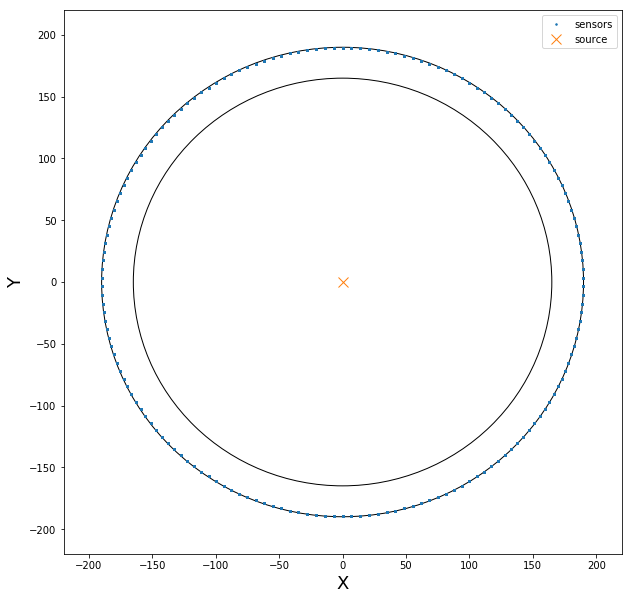

In [8]:
sens_pos   = ats.sensor_position(h5in)
sens_pos_x = np.array([x[0] for x in sens_pos.values()])
sens_pos_y = np.array([x[1] for x in sens_pos.values()])
sens_pos_z = np.array([x[2] for x in sens_pos.values()])

source_xpos = source_ypos = source_zpos = 0
if unit_x == 'cm':
    source_xpos = float(numb_x)*10
    source_ypos = float(numb_y)*10
    source_zpos = float(numb_z)*10
else:
    source_xpos = float(numb_x)
    source_ypos = float(numb_y)
    source_zpos = float(numb_z)
    

## Define the ring
r_int = float(irad_ring)
r_ext = float(irad_ring) + float(depth_ring)
center_point = (0., 0.)

## Define the figure
fig = plt.figure(figsize=(10,10))
limits = r_ext + 30
plt.xlim(-limits, limits)
plt.ylim(-limits, limits)
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)

circ1 = plt.Circle(center_point, r_int, color='k', fill=False)
circ2 = plt.Circle(center_point, r_ext, color='k', fill=False)

ax = fig.gca()
ax.add_artist(circ1)
ax.add_artist(circ2)

## Plot the sensors
plt.plot( sens_pos_x,  sens_pos_y, '.', markersize=3,  label='sensors')
plt.plot(source_xpos, source_ypos, 'x', markersize=10, label='source')
plt.legend()

### Drawing of the ring in 3D

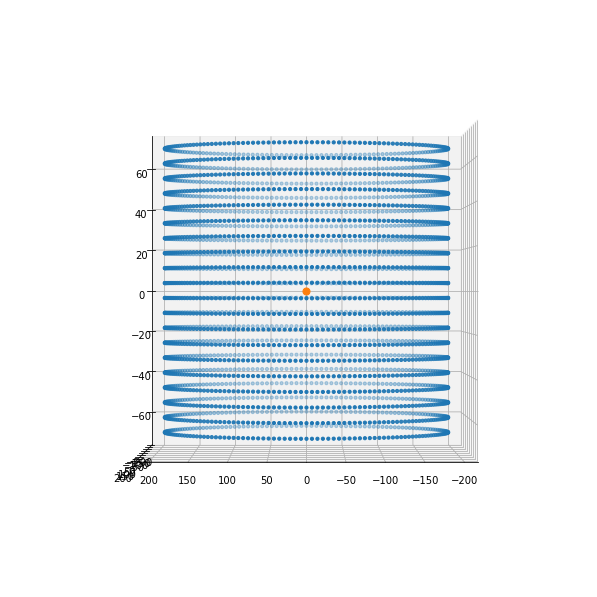

In [9]:
fig = plt.figure(figsize=(8,8))
ax  = Axes3D(fig)
ax.scatter( sens_pos_x,   sens_pos_y, sens_pos_z, marker='o', s=10)
ax.scatter(source_xpos, source_ypos, source_zpos, marker='o', s=50)
ax.view_init(azim=90, elev=0)

### Photoelectric analysis:

In [10]:
events_in_file = len(h5extents)
no_phot = single_phot = coincidences = 0
for evt in range(events_in_file):
    ave_true1, ave_true2 = rf.true_photoelect(h5in, filename, evt, compton=True)
    if len(ave_true1) and len(ave_true2):
        coincidences += 1
    elif len(ave_true1) or len(ave_true2):
        single_phot += 1
    else:
        no_phot += 1
print(no_phot, single_phot, coincidences)

34 6249 1485


#### Number of coincidences from charges:

In [5]:
from   antea.io.mc_io_tb              import read_SiPM_bin_width_from_conf
from   antea.io.mc_io_tb              import go_through_file
from   antea.utils.table_functions    import load_rpos
from invisible_cities.io  .mcinfo_io  import read_mcinfo

source = '0.5.5'
start  = 0
numb   = 1

base_path  = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/Christoff_sim/compton'
data_path  = '/Users/carmenromoluque/Desktop/testsss/0.5.5/'
evt_file    = f"{data_path}/full_ring_irad15cm_d3cm_p7mm_reco_from_sensors_coinc_{source}_{start}_{numb}"
rpos_file   = base_path+'/r_sigma_phi_table_iradius165mm_thr4pes_depth3cm_compton_sel_photopeak_new.h5'
Rpos        = ats.load_rpos(rpos_file, group = "Radius", node  = "f4pes150bins")

rpos_threshold = 4
phi_threshold  = 5
zpos_threshold = 4
e_threshold    = 2

events = []

sens_pos       = ats.sensor_position    (h5in)
bin_width      = read_SiPM_bin_width_from_conf(h5in)

charge_range = (1000, 1400)

events_in_file = len(h5extents)
for evt in range(events_in_file):
    event_number   = h5in.root.MC.extents[evt]['evt_number']
    this_event_wvf = go_through_file(h5in, h5in.root.MC.waveforms, (evt, evt+1), bin_width, 'data')
    sns_over_thr, charges_over_thr = ats.find_SiPMs_over_threshold(this_event_wvf, e_threshold)
    if len(charges_over_thr) == 0: continue

    this_event_dict = read_mcinfo(h5in, (evt, evt+1))
    part_dict       = list(this_event_dict.values())[0]
    i1, i2, pos_true1, pos_true2, _, _, q1, q2, pos1, pos2 = ats.select_true_pos_from_charge(sns_over_thr, charges_over_thr, charge_range, sens_pos, part_dict)

    if i1 and i2:
        positions1, qs1 = ots.reco_pos_single(pos_true1, np.array(q1), np.array(pos1), rpos_threshold, phi_threshold, zpos_threshold)
        positions2, qs2 = ots.reco_pos_single(pos_true2, np.array(q2), np.array(pos2), rpos_threshold, phi_threshold, zpos_threshold)

        if len(positions1) == 0 or len(positions2) == 0:
            continue

        events.append(event_number)

a_events = np.array(events)
print(len(a_events))

Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
Houston, we've got a problem 1: both gammas interact in the same emisphere. This event cannot be used to join singles.
58


## Analysis from npz file:

In [11]:
import matplotlib.pyplot as plt

In [12]:
true_r1, true_phi1, true_z1 = [], [], []
true_r2, true_phi2, true_z2 = [], [], []
reco_r1, reco_phi1, reco_z1 = [], [], []
reco_r2, reco_phi2, reco_z2 = [], [], []
events, sns_response1, sns_response2 = [], [], []

#eventsPath = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/reflect_walls/no_refl_sipms/2_data_pos_charge_no_compton/'
eventsPath = '/data5/users/carmenromo/comparison_ring_confs/2_data_pos_charge_no_compton_rthr4pes/narrow_ring/'
for filename in os.listdir(eventsPath):
    if filename.endswith('.npz'):
        my_file   = eventsPath+filename
        print(filename)
        d = np.load(my_file)

        for i in d['a_true_r1']:
            true_r1.append(i)
        for i in d['a_true_r2']:
            true_r2.append(i)
        for i in d['a_true_phi1']:
            true_phi1.append(i)
        for i in d['a_true_phi2']:
            true_phi2.append(i)
        for i in d['a_true_z1']:
            true_z1.append(i)
        for i in d['a_true_z2']:
            true_z2.append(i)
            
        for i in d['a_reco_r1']:
            reco_r1.append(i)
        for i in d['a_reco_r2']:
            reco_r2.append(i)
        for i in d['a_reco_phi1']:
            reco_phi1.append(i)
        for i in d['a_reco_phi2']:
            reco_phi2.append(i)
        for i in d['a_reco_z1']:
            reco_z1.append(i)
        for i in d['a_reco_z2']:
            reco_z2.append(i)
            
        for i in d['a_sns_response1']:
            sns_response1.append(i)
        for i in d['a_sns_response2']:
            sns_response2.append(i)
        print(len(d['a_events']))
        for i in d['a_events']:
            events .append(i)
        
true_r1       = np.array(true_r1      )
true_r2       = np.array(true_r2      )
true_phi1     = np.array(true_phi1    )
true_phi2     = np.array(true_phi2    )
true_z1       = np.array(true_z1      )
true_z2       = np.array(true_z2      )
reco_r1       = np.array(reco_r1      )
reco_r2       = np.array(reco_r2      )
reco_phi1     = np.array(reco_phi1    )
reco_phi2     = np.array(reco_phi2    )
reco_z1       = np.array(reco_z1      )
reco_z2       = np.array(reco_z2      )
events        = np.array(events       )
sns_response1 = np.array(sns_response1)
sns_response2 = np.array(sns_response2)

true_x1 = true_r1*np.cos(true_phi1)
true_y1 = true_r1*np.sin(true_phi1)
true_x2 = true_r2*np.cos(true_phi2)
true_y2 = true_r2*np.sin(true_phi2)
reco_x1 = reco_r1*np.cos(reco_phi1)
reco_y1 = reco_r1*np.sin(reco_phi1)
reco_x2 = reco_r2*np.cos(reco_phi2)
reco_y2 = reco_r2*np.sin(reco_phi2)
        
print(len(events))

full_ring_irad165mm_depth2.5cm_reco_pos_charge_230_10_6_0.npz
1163
full_ring_irad165mm_depth2.5cm_reco_pos_charge_0_10_6_0.npz
1114
full_ring_irad165mm_depth2.5cm_reco_pos_charge_260_10_6_0.npz
1157
full_ring_irad165mm_depth2.5cm_reco_pos_charge_160_10_6_0.npz
1139
full_ring_irad165mm_depth2.5cm_reco_pos_charge_100_10_6_0.npz
1090
full_ring_irad165mm_depth2.5cm_reco_pos_charge_400_10_6_0.npz
1103
full_ring_irad165mm_depth2.5cm_reco_pos_charge_170_10_6_0.npz
1166
full_ring_irad165mm_depth2.5cm_reco_pos_charge_410_10_6_0.npz
1115
full_ring_irad165mm_depth2.5cm_reco_pos_charge_460_10_6_0.npz
1159
full_ring_irad165mm_depth2.5cm_reco_pos_charge_290_10_6_0.npz
1112
full_ring_irad165mm_depth2.5cm_reco_pos_charge_350_10_6_0.npz
1139
full_ring_irad165mm_depth2.5cm_reco_pos_charge_150_10_6_0.npz
1107
full_ring_irad165mm_depth2.5cm_reco_pos_charge_340_10_6_0.npz
1154
full_ring_irad165mm_depth2.5cm_reco_pos_charge_330_10_6_0.npz
1136
full_ring_irad165mm_depth2.5cm_reco_pos_charge_120_10_6_0.npz
10

Text(0,0.5,'Reco y')

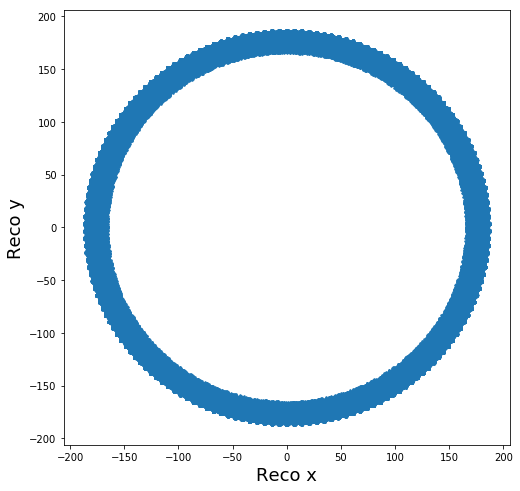

In [13]:
true_x = np.concatenate((true_x1, true_x2), axis=0)
true_y = np.concatenate((true_y1, true_y2), axis=0)
reco_x = np.concatenate((reco_x1, reco_x2), axis=0)
reco_y = np.concatenate((reco_y1, reco_y2), axis=0)
plt.figure(figsize=(8,8))
plt.plot(reco_x, reco_y, '.', markersize=3)
plt.xlabel('Reco x', size=18)
plt.ylabel('Reco y', size=18)

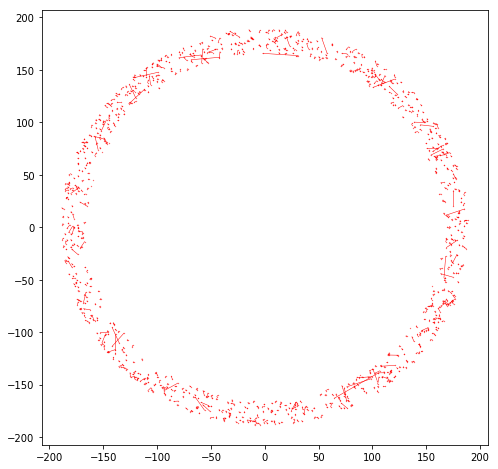

In [14]:
plt.figure(figsize=(8,8))
for (tx1, ty1, rx1, ry1) in zip(true_x1[:1000], true_y1[:1000], reco_x1[:1000], reco_y1[:1000]):
    xs = np.array([tx1, rx1])
    ys = np.array([ty1, ry1])
    dist = np.sqrt((tx1-rx1)**2 + (ty1-ry1)**2)
    plt.plot(xs, ys, '.', markersize=0.5, linestyle='-', linewidth=0.5, c='r')

Text(0,0.5,'Reco y')

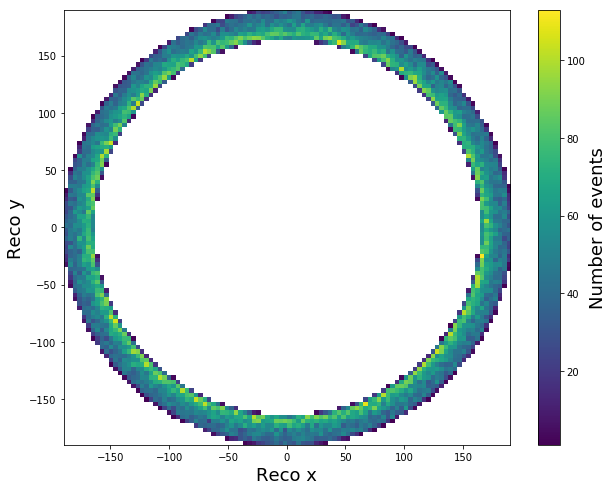

In [16]:
xbins  = 100
ybins  = 100

plt.figure(figsize=(10, 8))
sel = ~np.isnan(reco_x) & ~np.isnan(reco_y)
nevt, *_ = plt.hist2d(true_x[sel], true_y[sel], (xbins, ybins), cmin=1)
plt.colorbar().set_label("Number of events", size=18)
plt.xlabel('Reco x', size=18)
plt.ylabel('Reco y', size=18)